##### Aldo Daniel Villaseñor Fierro
##### A01637907

In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import graphviz

#### En el siguiente documento se crea un modelo de machine learning para la clasificación de tumores en las categorías maligno y benigno en base a características obtenidas de estudios médicos

#### Exportando datos de archivo csv y creando variable dummy 'lbl_n' para la clasificación

In [20]:
df_main=pd.read_csv('wdbc.data',encoding = 'unicode_escape', engine ='python')
df_main['lbl_n']= df_main.lbl.replace({'M':1,'B':0})

#### Se toman solo variables que tengan una correlación mayor a 0.5 con la variable a clasificar 

In [21]:
m = df_main.corr()
m = m[m['lbl_n']>0.5]
df = df_main.drop(['lbl','lbl_n'],axis=1)

C:\Users\Aldo\AppData\Local\Temp\ipykernel_17944\3253081848.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  m = df_main.corr()


#### Escalando variables a utilizar para entrenar el modelo

In [22]:
x_train, x_test, y_train , y_test = train_test_split(df,df_main.lbl_n,test_size=0.2,random_state=42)#, random_state=42)
x_train, x_validation, y_train , y_validation = train_test_split(x_train,y_train,test_size=0.2,random_state=42)#, random_state=42)

scaler=MinMaxScaler()
scaler.fit(df)

x_train_t=scaler.transform(x_train)
x_validation_t=scaler.transform(x_validation)

#### Definiendo el modelo, se utilizará un Arbol de Desición utilizando la libreria sci-kit learn

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score

model_tree=DecisionTreeClassifier(criterion='entropy',max_features='log2')
model_tree.fit(x_train_t,y_train)


DecisionTreeClassifier(criterion='entropy', max_features='log2')

In [24]:
import optuna
import sklearn.model_selection

def objective(trial):

    # Define the hyperparameter search space
    criterion = trial.suggest_categorical("criterion", ['gini','entropy','log_loss'])  # Suggested range for 'nu'
    splitter = trial.suggest_categorical("splitter", ["best", "random"])  # Suggested range for 'kernel'
    max_features = trial.suggest_categorical("max_features", ['auto','sqrt','log2'])  # Suggested range for 'gamma'
    max_depth = trial.suggest_int("max_depth", 1, 8)  # Suggested range for 'degree'
    min_samples_split = trial.suggest_int("min_samples_split", 2.0, 31.0)  # Suggested range for 'coef0'
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1.0, 30.0)  # Suggested range for 'gamma'
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 7.0)  # Suggested range for 'C'
    

    classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        random_state=42,
    )

    # Evaluate the classifier using cross-validation
    score = sklearn.model_selection.cross_val_score(
        classifier, x_train_t, y_train, n_jobs=-1, cv=3
    )  # Adjust the number of folds as needed

    # Calculate the mean accuracy from cross-validation
    accuracy = score.mean()

    return accuracy

def prune_callback(study, trial):
    if trial.state == optuna.trial.TrialState.RUNNING:
        if study.best_value is not None and trial.value is not None:
            if trial.value < study.best_value * 0.8:  # Prune if the trial's value is significantly worse
                raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, callbacks=[prune_callback])

# Get the best hyperparameters and accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:")
print(best_params)
print(f"Best Accuracy: {best_accuracy:.4f}")

[I 2023-09-05 17:10:00,762] A new study created in memory with name: no-name-69a84f1b-da62-4b5d-a372-b7c5a7d615dd
[I 2023-09-05 17:10:06,149] Trial 0 finished with value: 0.6346249379036264 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 28, 'min_samples_leaf': 29, 'ccp_alpha': 3.039458715066953}. Best is trial 0 with value: 0.6346249379036264.
[I 2023-09-05 17:10:08,406] Trial 1 finished with value: 0.6346249379036264 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 2, 'ccp_alpha': 3.274603895731607}. Best is trial 0 with value: 0.6346249379036264.
[I 2023-09-05 17:10:10,689] Trial 2 finished with value: 0.6346249379036264 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 29, 'min_samples_leaf': 3, 'ccp_alpha': 6.890366967259395}. Best is trial 0

Best Hyperparameters:
{'criterion': 'entropy', 'splitter': 'best', 'max_features': 'auto', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'ccp_alpha': 0.0011457371973159118}
Best Accuracy: 0.9367


In [25]:
model_t=DecisionTreeClassifier(**best_params)
model_t.fit(x_train_t,y_train)

c:\Users\Aldo\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(ccp_alpha=0.0011457371973159118, criterion='entropy',
                       max_depth=8, max_features='auto', min_samples_split=10)

#### Méticas del modelo para el set de training

In [26]:
y_hat_t=model_tree.predict(x_train_t)

y_hat_train=y_hat_t

model_t_acc=accuracy_score(y_train,y_hat_t)
model_t_f1=f1_score(y_train,y_hat_t)
model_t_auc=roc_auc_score(y_train,y_hat_t)

print(model_t_acc)
print(model_t_f1)
print(model_t_auc)
confusion_matrix(y_train,y_hat_t)

1.0
1.0
1.0


array([[231,   0],
       [  0, 133]], dtype=int64)

In [27]:
y_hat_t=model_t.predict(x_train_t)#modelo optimizado con optuna

y_hat_train=y_hat_t

model_t_acc=accuracy_score(y_train,y_hat_t)
model_t_f1=f1_score(y_train,y_hat_t)
model_t_auc=roc_auc_score(y_train,y_hat_t)

print(model_t_acc)
print(model_t_f1)
print(model_t_auc)
confusion_matrix(y_train,y_hat_t)

0.978021978021978
0.9699248120300752
0.976304397357029


array([[227,   4],
       [  4, 129]], dtype=int64)

#### Métricas del modelo para el set de Validation

In [28]:
y_hat_t=model_tree.predict(x_validation_t)

model_t_acc=accuracy_score(y_validation,y_hat_t)
model_t_f1=f1_score(y_validation,y_hat_t)
model_t_auc=roc_auc_score(y_validation,y_hat_t)

print(model_t_acc)
print(model_t_f1)
print(model_t_auc)
confusion_matrix(y_validation,y_hat_t)

0.9230769230769231
0.9014084507042254
0.9171717171717172


array([[52,  3],
       [ 4, 32]], dtype=int64)

In [30]:
y_hat_t=model_t.predict(x_validation_t)

model_t_acc=accuracy_score(y_validation,y_hat_t)
model_t_f1=f1_score(y_validation,y_hat_t)
model_t_auc=roc_auc_score(y_validation,y_hat_t)

print('Accuracy: ',model_t_acc)
print('roc auc:',model_t_auc)
print('F1 score:',model_t_f1)
confusion_matrix(y_validation,y_hat_t)

Accuracy:  0.945054945054945
roc auc: 0.9401515151515151
F1 score: 0.9295774647887323


array([[53,  2],
       [ 3, 33]], dtype=int64)

#### Tras realizar pruebas para optimizar los parametros del modelo mediante la libreria optuna la mejor configuración para el modelo de arbol de decisión fue model_tree=DecisionTreeClassifier(criterion='entropy',max_features='log2') el cual obtuvo las mejores metricas en todas las pruebas. Se separó el set de treining en uno extra de validation para reaizar dichas pruebas

#### plot bar con las feature importances de cada variable utilizada por el modelo

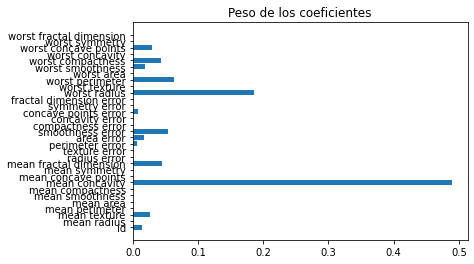

In [ ]:
plt.barh(list(df.columns),list(model_tree.feature_importances_))
plt.title("Peso de los coeficientes")
plt.show()

#### Data Frame con las variables utilizadas y una columna para comparar predicciones hechas por el modelo y el valor real del set de datos

In [ ]:
y_hat=model_tree.predict(x_test)
df_pruebas=pd.DataFrame()
df_pruebas['prediction'] = np.concatenate((y_hat,y_hat_train))
df_pruebas['real'] = np.concatenate((y_test,y_train))
df_pruebas[df.columns] = pd.concat([x_test,x_train],ignore_index=True)
df_pruebas

c:\Users\Aldo\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


,prediction,real,id,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,0,87930,12.47,18.60,81.09,481.9,0.09965,0.10580,0.08005,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.26710,0.10150,0.3014,0.08750
1,1,1,859575,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.10800,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.26870,0.17890,0.2551,0.06589
2,1,1,8670,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.37910,0.15140,0.2837,0.08019
3,1,0,907915,12.40,17.68,81.47,467.8,0.10540,0.13160,0.07741,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.24030,0.07370,0.2556,0.09359
4,1,0,921385,11.54,14.44,74.65,402.9,0.09984,0.11200,0.06737,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.17970,0.06918,0.2329,0.08134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,1,1,857793,14.71,21.59,95.55,656.9,0.11370,0.13650,0.12930,...,17.87,30.70,115.70,985.5,0.1368,0.4290,0.35870,0.18340,0.3698,0.10940
474,1,1,914062,18.01,20.56,118.40,1007.0,0.10010,0.12890,0.11700,...,21.53,26.06,143.40,1426.0,0.1309,0.2327,0.25440,0.14890,0.3251,0.07625
475,0,0,906024,12.70,12.17,80.88,495.0,0.08785,0.05794,0.02360,...,13.65,16.92,88.12,566.9,0.1314,0.1607,0.09385,0.08224,0.2775,0.09464
476,0,1,90291,14.60,23.29,93.97,664.7,0.08682,0.06636,0.08390,...,15.79,31.71,102.20,758.2,0.1312,0.1581,0.26750,0.13590,0.2477,0.06836


In [ ]:
df_pruebas.iloc[np.random.randint(len(x_test), size=(3))]


,prediction,real,id,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
31,1,0,871122,12.06,12.74,76.84,448.6,0.09311,0.05241,0.01972,...,13.14,18.41,84.08,532.8,0.1275,0.1232,0.08636,0.07025,0.2514,0.07898
60,1,0,8610908,12.86,18.00,83.19,506.3,0.09934,0.09546,0.03889,...,14.24,24.82,91.88,622.1,0.1289,0.2141,0.17310,0.07926,0.2779,0.07918
60,1,0,8610908,12.86,18.00,83.19,506.3,0.09934,0.09546,0.03889,...,14.24,24.82,91.88,622.1,0.1289,0.2141,0.17310,0.07926,0.2779,0.07918


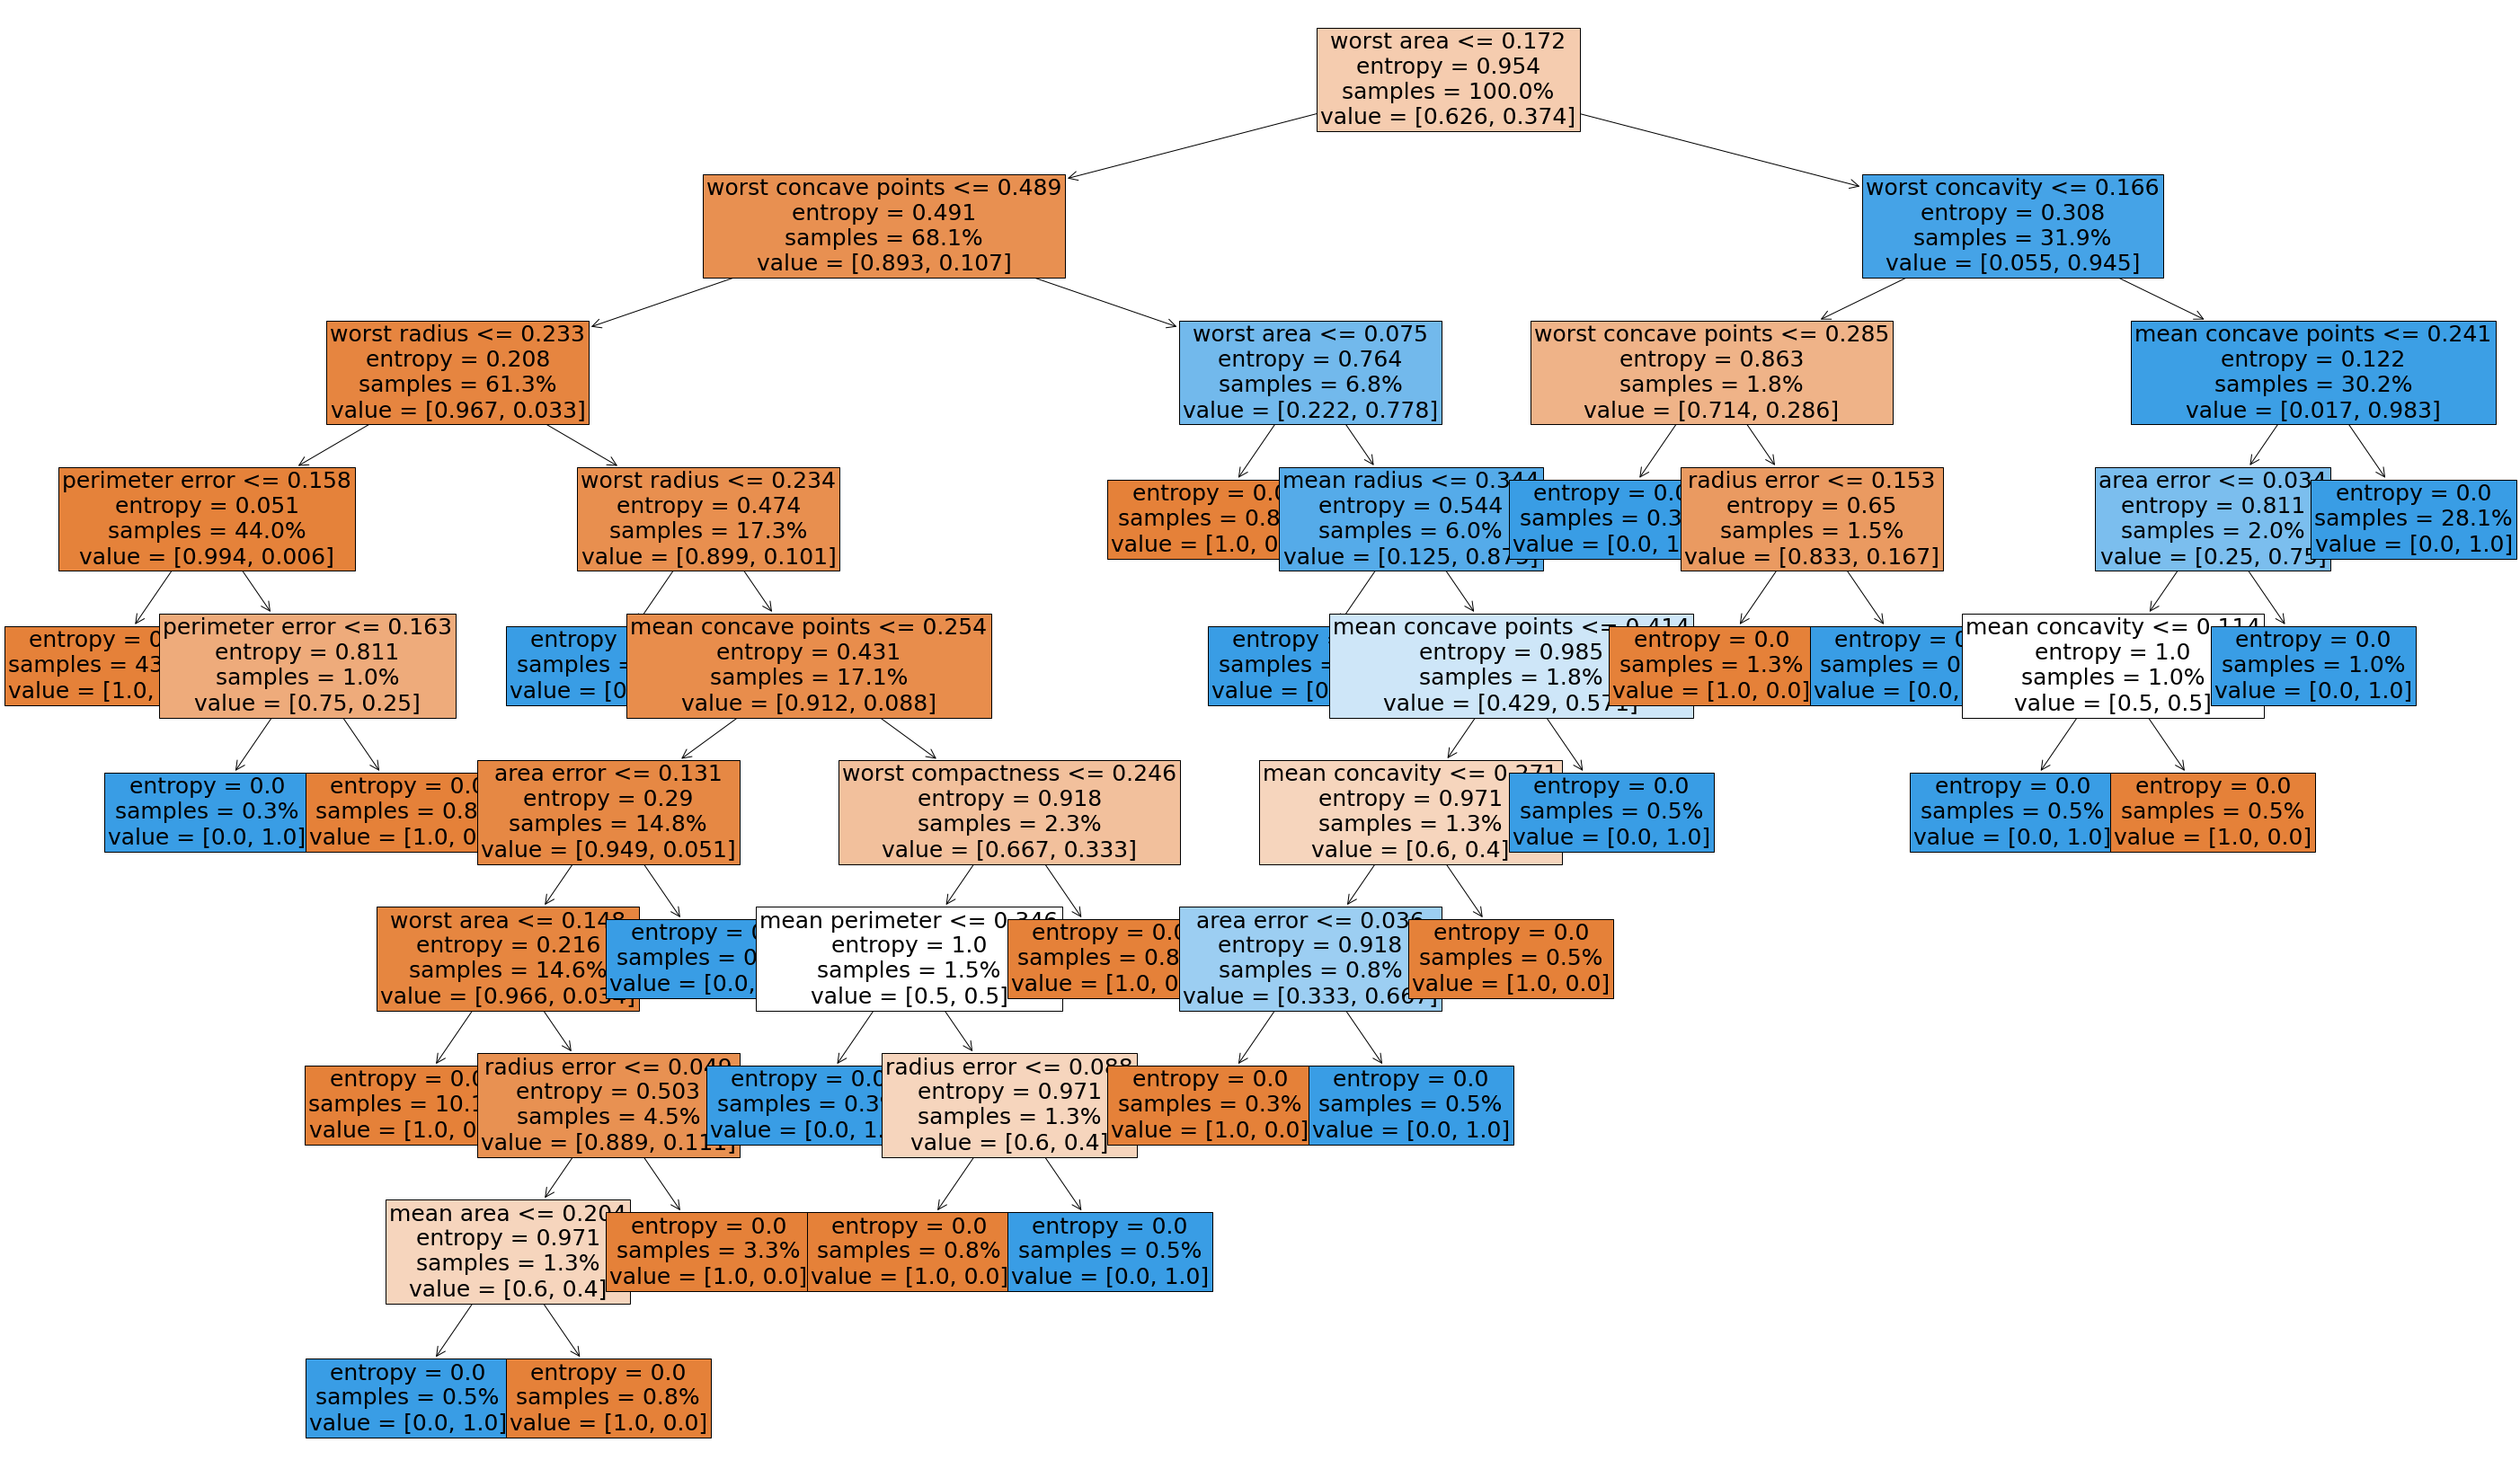

In [ ]:
plt.figure(figsize=(50,30))
tree.plot_tree(model_tree,feature_names=df_pruebas.columns[2:],fontsize=25,filled=True,proportion=True)
plt.show()